In [1]:
from glob import glob
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import pandas as pd
from scipy.interpolate import interp1d
from scipy.signal import gaussian, convolve
from statistics import mean, median
from scipy.optimize import curve_fit, least_squares
import collections

import utils

In [2]:
from getpass import getpass
from glob import glob

import numpy as np
import pylab as plt
from astropy import stats, units as u
from mpl_toolkits.axes_grid1.inset_locator import inset_axes, mark_inset
from matplotlib.ticker import MaxNLocator


import pandas as pd
from scipy.interpolate import interp1d
from scipy.signal import gaussian, convolve
from statistics import mean, median

from scipy.optimize import curve_fit, least_squares
import collections

import utils

# Data Lab
from dl import authClient as ac, queryClient as qc, storeClient as sc
from dl.helpers.utils import convert

# plotting setup
fontsize = 14
plt.rcParams['font.size'] = fontsize
plt.rcParams['axes.titlesize'] = fontsize

In [3]:
import var
from astropy.io import fits

In [4]:
def get_fltrs(df):
    fs = collections.Counter(star['filter'])
    order = ['u','b','v','g','r','i','z','Y','VR']
    include = set()
    for f in fs:
        if fs[f]>25:
            include.add(f)
    fltrs=[]
    for f in order:
        if f in include:
            fltrs.append(f)
    return fltrs

def get_tmps(fltrs):
    tmps=[]
    typs =[]
    for fltr in fltrs:
        typ = []
        templets = glob('templets/*{}.dat'.format(fltr))
        tmp = np.zeros((len(templets),501,2))
        for i in range(len(templets)):
            tmp[i] = np.concatenate((np.array([[0,0]]),
                                     np.array(pd.read_csv(templets[i],sep=' ')),
                                     np.array([[1,0]])))
            #adjust if filepath to templets changes
            if len(templets[i])==17:
                typ.append('RRab')
            elif len(templets[i])==15:
                typ.append('RRc')
        typs.append(typ)
        
        tmps.append(tmp)
    return tmps, typs

def double_tmps(tmps):
    tmps2=[]
    for f in range(len(tmps)):
        tmps2.append(np.tile(tmps[f],(2,1)))
        tmps2[f][:,int(len(tmps2[f][0])/2):,0] += 1
    return tmps2

def get_ls_period(t,y,min_freq=1./1.,max_freq=1./0.1):
    """Use Lomb-Scargle periodogram to get an estimate on period"""
    
    ls = stats.LombScargle(t, y)
    frequency, power = ls.autopower(minimum_frequency=min_freq,maximum_frequency=max_freq)
    period = 1./frequency # period is the inverse of frequency
    
    return period[np.argmax(power)]

def get_data(df,fltrs):
    best_periods = np.zeros(len(fltrs))
    crv=[]
    for i in range(len(fltrs)):
        selfltr = (df['filter'] == fltrs[i])
        selfwhm = (df['fwhm'] <= 4.0)
        sel = selfltr & selfwhm
        t = df['mjd'][sel].values
        y = df['mag_auto'][sel].values
        dy = df['magerr_auto'][sel].values
        
        best_periods[i] = get_ls_period(t,y)
        crvi = np.vstack((t,y-min(y),dy)).T
        crv.append(crvi[np.argsort(crvi[:,0])])
        crv[-1]
    return mean(best_periods), crv

def get_pinit(crv,period):
    pinit = ()
    for ltcrv in crv:
        pinit += ((0.0,max(ltcrv[:,1]),0.0),)
    pinit += (period,)
    return pinit

def RemoveOutliers(crv,tmps,p,pars):
    n = pars[:,-1].astype(int)
    crv_in = []
    for i in range(len(crv)):
        f = interp1d(tmps[i][n[i],:,0],tmps[i][n[i],:,1]*pars[i,1]+pars[i,2])
        phase = (crv[i][:,0]/p-pars[i,0]) %1
        dif = abs(crv[i][:,1]-f(phase))
        crv_in.append(crv[i][dif<utils.mad(dif)*5])
    return crv_in

def double_period(crv,p,pars):
    crv2 = []
    for i in range(len(crv)):
        crv2.append(crv[i].copy())
        crv2[i][:,1] -= pars[i,2]
        
        crv2[i][:,0] = (crv2[i][:,0]/p-pars[i,0])%1
        crv2[i] = np.tile(crv2[i].T,2).T
        crv2[i][int(len(crv2[i])/2):,0] += 1
        crv2[i] = crv2[i][crv2[i][:,0].argsort()]
        
    return crv2



In [5]:
class tmpfitter:
    def __init__ (self, tmps):
        self.fltr=0
        self.n=0
        self.tmps=tmps

    def model(self, t, t0, amplitude, yoffset):
        # modify the template using peak-to-peak amplitude, yoffset
        # fold input times t by period, phase shift to match template
        xtemp = self.tmps[self.fltr][self.n,:,0]
        ytemp = self.tmps[self.fltr][self.n,:,1]*amplitude + yoffset
        ph = (t - t0) %1
        #print((ph[0],period,t0%1))
        #print((period,t0,amplitude,yoffset))
        # interpolate the modified template to the phase we want
        return interp1d(xtemp,ytemp)(ph)


def tmpfit(tmps,crv,pinit,w=.1,steps=21,n=1):
    fitter = tmpfitter(tmps)
    
    lsteps = int(steps/2+.5)
    rsteps = steps - lsteps
    pl = np.linspace(pinit[-1]-w,pinit[-1],lsteps)
    pr = np.linspace(pinit[-1]+w,pinit[-1],rsteps,endpoint=False)
    plist = np.zeros(pl.size+pr.size)
    plist[0::2] = np.flip(pl)
    plist[1::2] = np.flip(pr)
    plist = plist[plist>0]
    
    pars = np.zeros((len(tmps),4))
    minsumx2 = 10**50
    minp = 0
    for p in plist:
        sumx2=0
        ppars=np.zeros((len(tmps),4))
        for f in range(len(tmps)):
            fitter.fltr = f
            phase = crv[f][:,0]/p%n #1 for one period, 2 for two periods
            minx2 = 10**50
            for i in range(len(tmps[f])):
                fitter.n = i
                try:
                    tpars, cov = curve_fit(fitter.model, phase, crv[f][:,1], 
                                          bounds = ((-.5,0,-50),(.5,10,50)),
                                          sigma=crv[f][:,2], p0=pinit[f], maxfev=1000)
                except RuntimeError:
                    print('Error: Curve_fit failed on templet={}:{}, p={:.4}'.format(fltr,i,p))
                    break
                
                x2 = sum((fitter.model(phase,tpars[0],tpars[1],tpars[2])-crv[f][:,1])**2/crv[f][:,2])
                if x2 < minx2:
                    ppars[f,:-1] = tpars
                    ppars[f,-1] = i
                    minx2 = x2
            
            sumx2 += minx2
            if sumx2 > minsumx2:
                break
        if sumx2 < minsumx2:
            minsumx2 = sumx2
            minp = p
            pars = ppars
    return minp, pars

In [6]:
objname = '150537_4644'
star=qc.query(sql="""SELECT meas.* 
                     FROM nsc_dr2.meas
                     WHERE objectid='{:s}'""".format(objname),
              fmt='pandas',
              profile='db01')

fltrs = get_fltrs(star)
tmps, typs = get_tmps(fltrs)
period,crv = get_data(star,fltrs)
print(collections.Counter(star['filter']))
print('period estimate: {:.4f} days'.format(period))

Counter({'g': 106, 'r': 51, 'i': 39, 'Y': 2, 'z': 2})
period estimate: 0.3371 days


In [7]:
pinit = get_pinit(crv,period)
%time p,pars = tmpfit(tmps,crv,pinit,w=.1,steps=25)

pinit = ()
for i in range(len(pars)):
    pinit += (tuple(pars[i,:-1]),)
pinit += (p,)
crv_in = RemoveOutliers(crv,tmps,p,pars)

%time p_in, pars_in = tmpfit(tmps, crv_in, pinit,w=.01,steps=25)
print('Old:\nPeriod: {:.3} days'.format(p))
for i in range(len(pars)):
    print('{0}: Templet #{4:.0f}, Phase: {1:.4f}, Amp: {2:.4f},  YOffset: {3:.4f}'.format(fltrs[i],*pars[i]))
print('New:\nPeriod: {:.3} days'.format(p_in))
for i in range(len(pars)):
    print('{0}: Templet #{4:.0f}, Phase: {1:.4f}, Amp: {2:.4f},  YOffset: {3:.4f}'.format(fltrs[i],*pars_in[i]))

CPU times: user 9.11 s, sys: 4.46 ms, total: 9.11 s
Wall time: 9.11 s
CPU times: user 9.68 s, sys: 3.97 ms, total: 9.69 s
Wall time: 9.69 s
Old:
Period: 0.337 days
g: Templet #13, Phase: -0.0783, Amp: 0.4791,  YOffset: 0.0259
r: Templet #12, Phase: -0.0628, Amp: 0.3301,  YOffset: 0.0134
i: Templet #12, Phase: -0.0728, Amp: 0.2381,  YOffset: 0.0023
New:
Period: 0.337 days
g: Templet #13, Phase: -0.0788, Amp: 0.4788,  YOffset: 0.0257
r: Templet #12, Phase: -0.0621, Amp: 0.3324,  YOffset: 0.0117
i: Templet #11, Phase: -0.0504, Amp: 0.2525,  YOffset: 0.0052


In [8]:
crv2 = double_period(crv,p_in,pars_in)
tmps2= double_tmps(tmps)
pars2= pars_in
n = pars[:,-1].astype(int)

colors = []
for f in fltrs:
    if f == 'r' or f == 'g':
        colors.append(f)
    else:
        colors.append('black')

In [9]:
consistent = True
for i in range(len(typs)):
    for j in range(i+1,len(typs)):
        if typs[i][n[i]] != typs[j][n[j]]:
            print('inconsistent RR type')
            consistent = False
            break
if consistent:
    typ = typs[0][n[0]]
else:
    typ = '???'

Text(0.5, 1.0, 'Object: 150537_4644    Period: 0.337 d    Type:RRc')

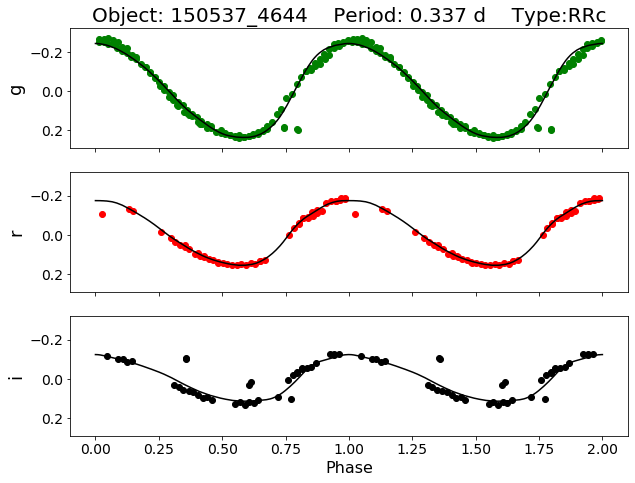

In [10]:
fig, ax = plt.subplots(len(crv2), figsize=(10,7.5), sharex=True, sharey=True)
for i in range(len(ax)):
    crvmean = mean(crv2[i][:,1])
    ax[i].scatter(crv2[i][:,0],crv2[i][:,1]-crvmean,c=colors[i])
    ax[i].plot(tmps2[i][n[i],:,0],tmps2[i][n[i],:,1]*pars[i,1]-crvmean,c='black')
    ax[i].invert_yaxis()
    ax[i].set_ylabel(fltrs[i], fontsize=18)
    
ax[-1].set_xlabel('Phase', fontsize=16)
ax[0].set_title("Object: {}    Period: {:.3f} d    Type:{}".format(objname,p_in,typ), fontsize=20)